# Libs

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os 
import warnings
from IPython.display import display
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from scipy.stats import shapiro, spearmanr, levene, kruskal, mannwhitneyu, chi2_contingency, ttest_ind
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
import pickle
sys.path.append(os.path.abspath(".."))

warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

# Paths

In [ ]:
path_processed_data = os.path.join('..', 'data','processed')
models_dir = os.path.join("..", "models")
reports_dir = os.path.join("..", "reports")


# Load

In [28]:
df_convo_deuda = pd.read_csv(os.path.join(path_processed_data, 'data.csv'))

# Transform

In [29]:
# Convertir las variables pertientes a categoricas
columnas_categoricas = ['DIA CERO', 'ID PROGRAMA',
       'TIPO PROGRAMA', 'NACIONALIDAD', 'PAÍS DE RESIDENCIA', 
       'MEDIO PAGO PI', 'MEDIO PAGO IMPORTE PENDIENTE', 
       'DIFERENCIA PI vs. IMPORTE PTE',
       'FORMA DE PAGO', 'ASESOR', 'Moroso',
       'FORMA DE PAGO ORIGINAL', 'AGRUPACION NACIONALIDAD', 
       'AGRUPACION PAÍS DE RESIDENCIA', 'MANTIENE MEDIO PAGO',
       'DIFERENCIA PI vs. IMPORTE PTE'
         ]
for col in columnas_categoricas:
    df_convo_deuda[col] = df_convo_deuda[col].astype('category')

# ML

## Entrenamiento preliminar

Con países y con tipología programa, sin agrupaciones de país ni agrupaciones de curso

,Modelo,Accuracy
0,Random Forest,0.926782
1,Decision Tree,0.890173
2,Logistic Regression,0.884393


,Modelo,Precision (Clase 1),Recall (Clase 1),F1-score (Clase 1),Precision (Clase 0),Recall (Clase 0),F1-score (Clase 0)
0,Random Forest,0.850575,0.747475,0.795699,0.942130,0.969048,0.955399
1,Decision Tree,0.701923,0.737374,0.719212,0.937349,0.926190,0.931737
2,Logistic Regression,0.760000,0.575758,0.655172,0.905405,0.957143,0.930556


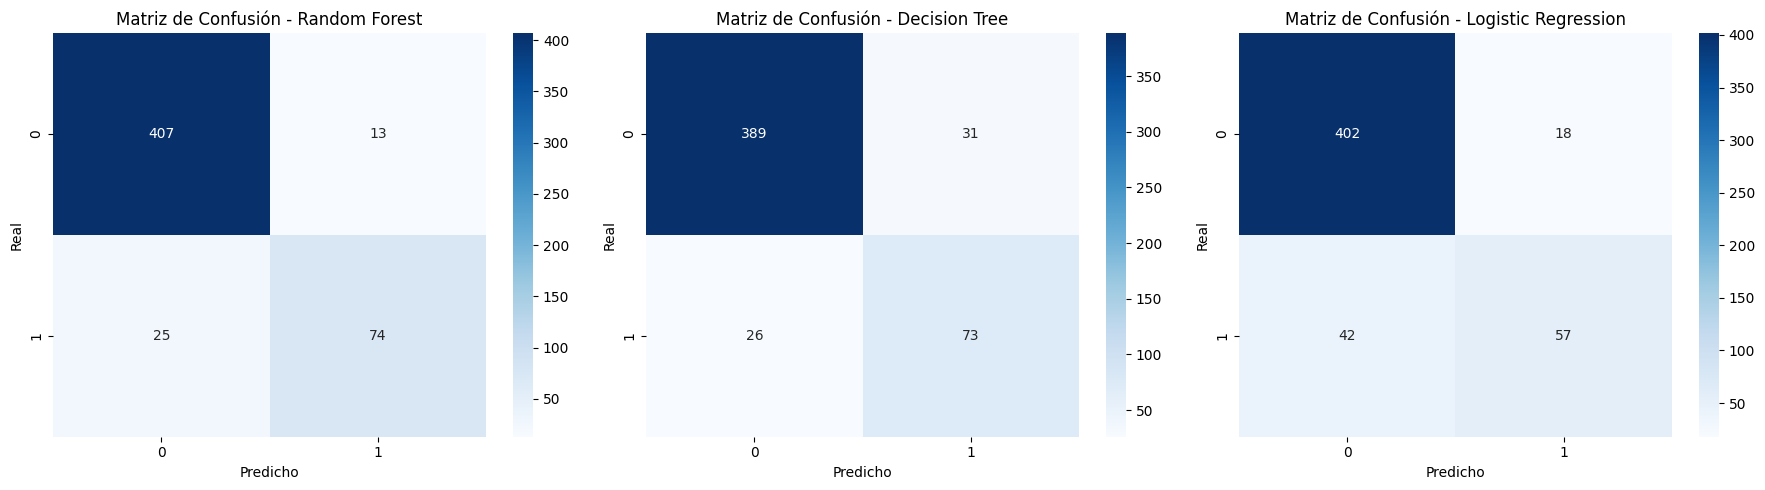

In [30]:
#df limpio
df = df_convo_deuda.copy().drop(columns= ['FECHA PRODUCCIÓN', 'FECHA 1ra CUOTA', 'FECHA 1ra CUOTA ORIGINAL',
                                           '% Impagado Actual Vdo', 'Importe Impagado Actual',
                                           'ID PROGRAMA', 'PRECIO CURSO', 'AGRUPACION NACIONALIDAD',
                                           'AGRUPACION PAÍS DE RESIDENCIA']) 

df.dropna(inplace=True)

# Label Encoders: Conversión categóricas
#Seleccionar columnas categoricas
categorical_cols = df.select_dtypes(include=['category']).columns

# Diccionario para guardar los LabelEncoders
label_encoders = {}

# Aplicar LabelEncoder por columna
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le  # Guardar el encoder para esa columna

#Entrenamiento
# Separar variables y objetivo
X = df.drop(columns=['Moroso'])
y = df['Moroso'].astype(int)

# Escalar solo para Logistic Regression
scaler = StandardScaler()
X_logistic = scaler.fit_transform(X)

# Modelos rápidos
modelos_rapidos = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

# Separar para árboles y para regresión logística
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_logistic, y, test_size=0.2, random_state=42)
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X, y, test_size=0.2, random_state=42)

resultados_rapidos = []

for nombre, modelo in modelos_rapidos.items():
    if nombre == 'Logistic Regression':
        modelo.fit(X_train_std, y_train_std)
        y_pred = modelo.predict(X_test_std)
    else:
        modelo.fit(X_train_tree, y_train_tree)
        y_pred = modelo.predict(X_test_tree)

    acc = accuracy_score(y_test_tree, y_pred)
    resultados_rapidos.append({
        'Modelo': nombre,
        'Accuracy': acc,
        'Reporte': classification_report(y_test_tree, y_pred, output_dict=True),
        'Matriz Confusión': confusion_matrix(y_test_tree, y_pred)
    })

# Crear DataFrame de resultados
resumen_rapidos = pd.DataFrame({
    'Modelo': [r['Modelo'] for r in resultados_rapidos],
    'Accuracy': [r['Accuracy'] for r in resultados_rapidos]
}).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

display(resumen_rapidos)

# Crear DataFrame con métricas detalladas
metricas = []

for resultado in resultados_rapidos:
    reporte = resultado['Reporte']
    metricas.append({
        'Modelo': resultado['Modelo'],
        'Precision (Clase 1)': reporte['1']['precision'],
        'Recall (Clase 1)': reporte['1']['recall'],
        'F1-score (Clase 1)': reporte['1']['f1-score'],
        'Precision (Clase 0)': reporte['0']['precision'],
        'Recall (Clase 0)': reporte['0']['recall'],
        'F1-score (Clase 0)': reporte['0']['f1-score']
    })

df_metricas = pd.DataFrame(metricas).sort_values(by='F1-score (Clase 1)', ascending=False).reset_index(drop=True)

# Mostrar tabla de métricas
display(df_metricas)


# Visualizar matrices de confusión
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, resultado in zip(axes, resultados_rapidos):
    cm = resultado['Matriz Confusión']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Matriz de Confusión - {resultado["Modelo"]}')
    ax.set_xlabel('Predicho')
    ax.set_ylabel('Real')

plt.tight_layout()
plt.show()



Decison Tree es el que mejor está prediciendo los morosos (pero aún así con una eficacia baja)
De manera general RF predice mejor el global de casos (F1-score del 79%)

## Balanceo de las clases

### ML con undersampling

,Modelo,Accuracy
0,Decision Tree,0.882653
1,Random Forest,0.862245
2,Logistic Regression,0.841837


,Modelo,Precision (Clase 1),Recall (Clase 1),F1-score (Clase 1),Precision (Clase 0),Recall (Clase 0),F1-score (Clase 0)
0,Decision Tree,0.923913,0.841584,0.880829,0.846154,0.926316,0.884422
1,Random Forest,0.885417,0.841584,0.862944,0.840000,0.884211,0.861538
2,Logistic Regression,0.937500,0.742574,0.828729,0.775862,0.947368,0.853081


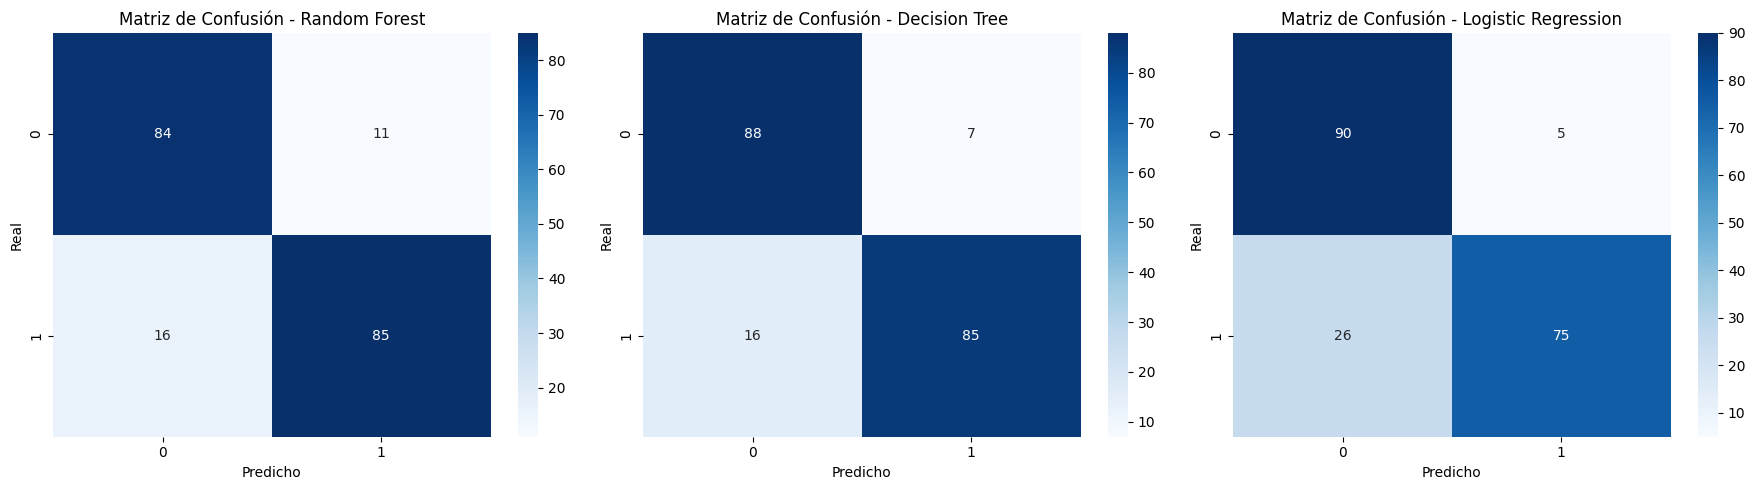

In [31]:
# Separar por clase
df_majority = df[df['Moroso'] == 0]
df_minority = df[df['Moroso'] == 1]

# Submuestreo de la mayoría
df_majority_downsampled = resample(df_majority,
                                   replace=False,
                                   n_samples=len(df_minority),
                                   random_state=42)

# Combinar
df_balanced = pd.concat([df_majority_downsampled, df_minority])
# Separar variables y objetivo
X = df_balanced.drop(columns=['Moroso'])
y = df_balanced['Moroso'].astype(int)

# Escalar solo para Logistic Regression
scaler = StandardScaler()
X_logistic = scaler.fit_transform(X)

# Modelos rápidos
modelos_rapidos = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

# Separar para árboles y para regresión logística
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(X_logistic, y, test_size=0.2, random_state=42)
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(X, y, test_size=0.2, random_state=42)

resultados_rapidos_balanced = []

for nombre, modelo in modelos_rapidos.items():
    if nombre == 'Logistic Regression':
        modelo.fit(X_train_std, y_train_std)
        y_pred = modelo.predict(X_test_std)
    else:
        modelo.fit(X_train_tree, y_train_tree)
        y_pred = modelo.predict(X_test_tree)

    acc = accuracy_score(y_test_tree, y_pred)
    resultados_rapidos_balanced.append({
        'Modelo': nombre,
        'Accuracy': acc,
        'Reporte': classification_report(y_test_tree, y_pred, output_dict=True),
        'Matriz Confusión': confusion_matrix(y_test_tree, y_pred)
    })

# Crear DataFrame de resultados
resumen_rapidos_balanceados = pd.DataFrame({
    'Modelo': [r['Modelo'] for r in resultados_rapidos_balanced],
    'Accuracy': [r['Accuracy'] for r in resultados_rapidos_balanced]
}).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)

display(resumen_rapidos_balanceados)

# Crear DataFrame con métricas detalladas
metricas_balanceadas = []

for resultado in resultados_rapidos_balanced:
    reporte_balanceado = resultado['Reporte']
    metricas_balanceadas.append({
        'Modelo': resultado['Modelo'],
        'Precision (Clase 1)': reporte_balanceado['1']['precision'],
        'Recall (Clase 1)': reporte_balanceado['1']['recall'],
        'F1-score (Clase 1)': reporte_balanceado['1']['f1-score'],
        'Precision (Clase 0)': reporte_balanceado['0']['precision'],
        'Recall (Clase 0)': reporte_balanceado['0']['recall'],
        'F1-score (Clase 0)': reporte_balanceado['0']['f1-score']
    })

df_metricas_balanceadas = pd.DataFrame(metricas_balanceadas).sort_values(by='F1-score (Clase 1)', ascending=False).reset_index(drop=True)

# Mostrar tabla de métricas
display(df_metricas_balanceadas)

# Visualizar matrices de confusión
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, resultado in zip(axes, resultados_rapidos_balanced):
    cm = resultado['Matriz Confusión']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Matriz de Confusión - {resultado["Modelo"]}')
    ax.set_xlabel('Predicho')
    ax.set_ylabel('Real')

plt.tight_layout()
plt.show()


Aumenta la precisió y el Recall de los 3 modelos de manera general.
Decison Tree sigue siendo el modelo con mayor precisión; llega al 92% en precisión y 88% en f1-score.

### ML con Oversampling

,Modelo,Accuracy
0,Random Forest,0.945368
1,Decision Tree,0.934679
2,Logistic Regression,0.868171


,Modelo,Precision (Clase 1),Recall (Clase 1),F1-score (Clase 1),Precision (Clase 0),Recall (Clase 0),F1-score (Clase 0)
0,Random Forest,0.939698,0.944444,0.942065,0.950450,0.946188,0.948315
1,Decision Tree,0.927318,0.934343,0.930818,0.941309,0.934978,0.938133
2,Logistic Regression,0.880000,0.833333,0.856031,0.858672,0.899103,0.878423


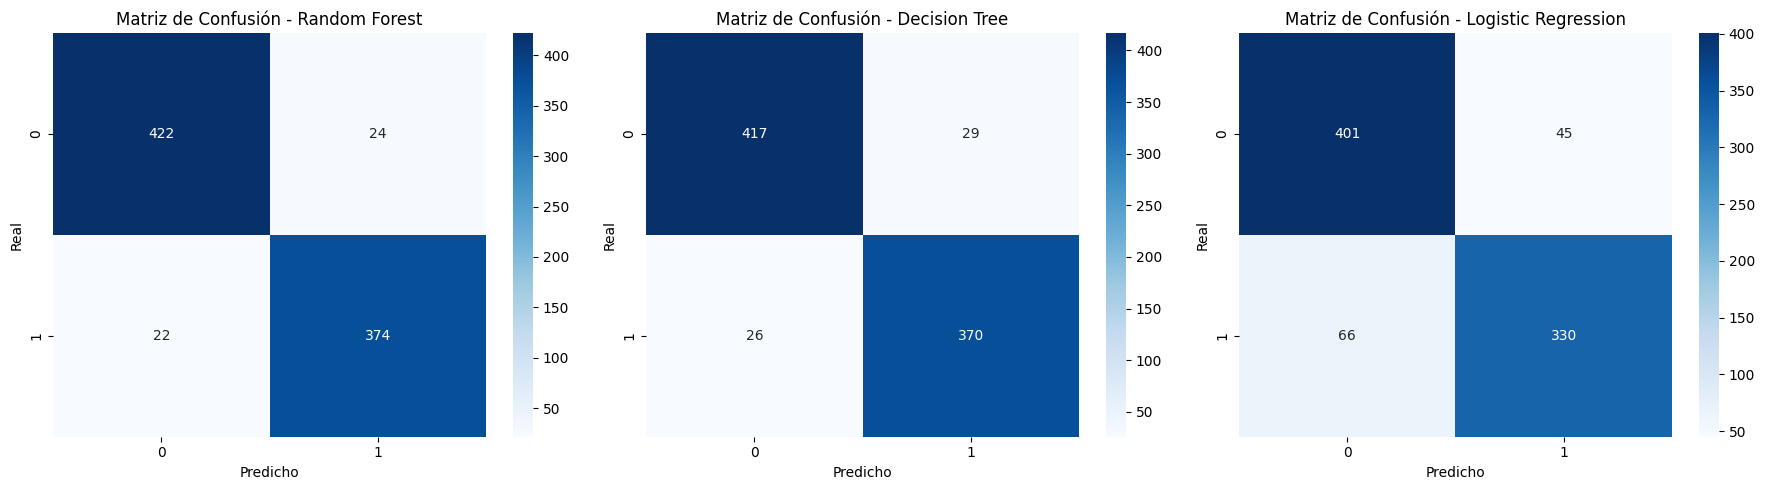

✅ Modelo guardado: ..\models\modelo_random_forest.pkl
✅ Modelo guardado: ..\models\modelo_decision_tree.pkl
✅ Modelo guardado: ..\models\modelo_logistic_regression.pkl


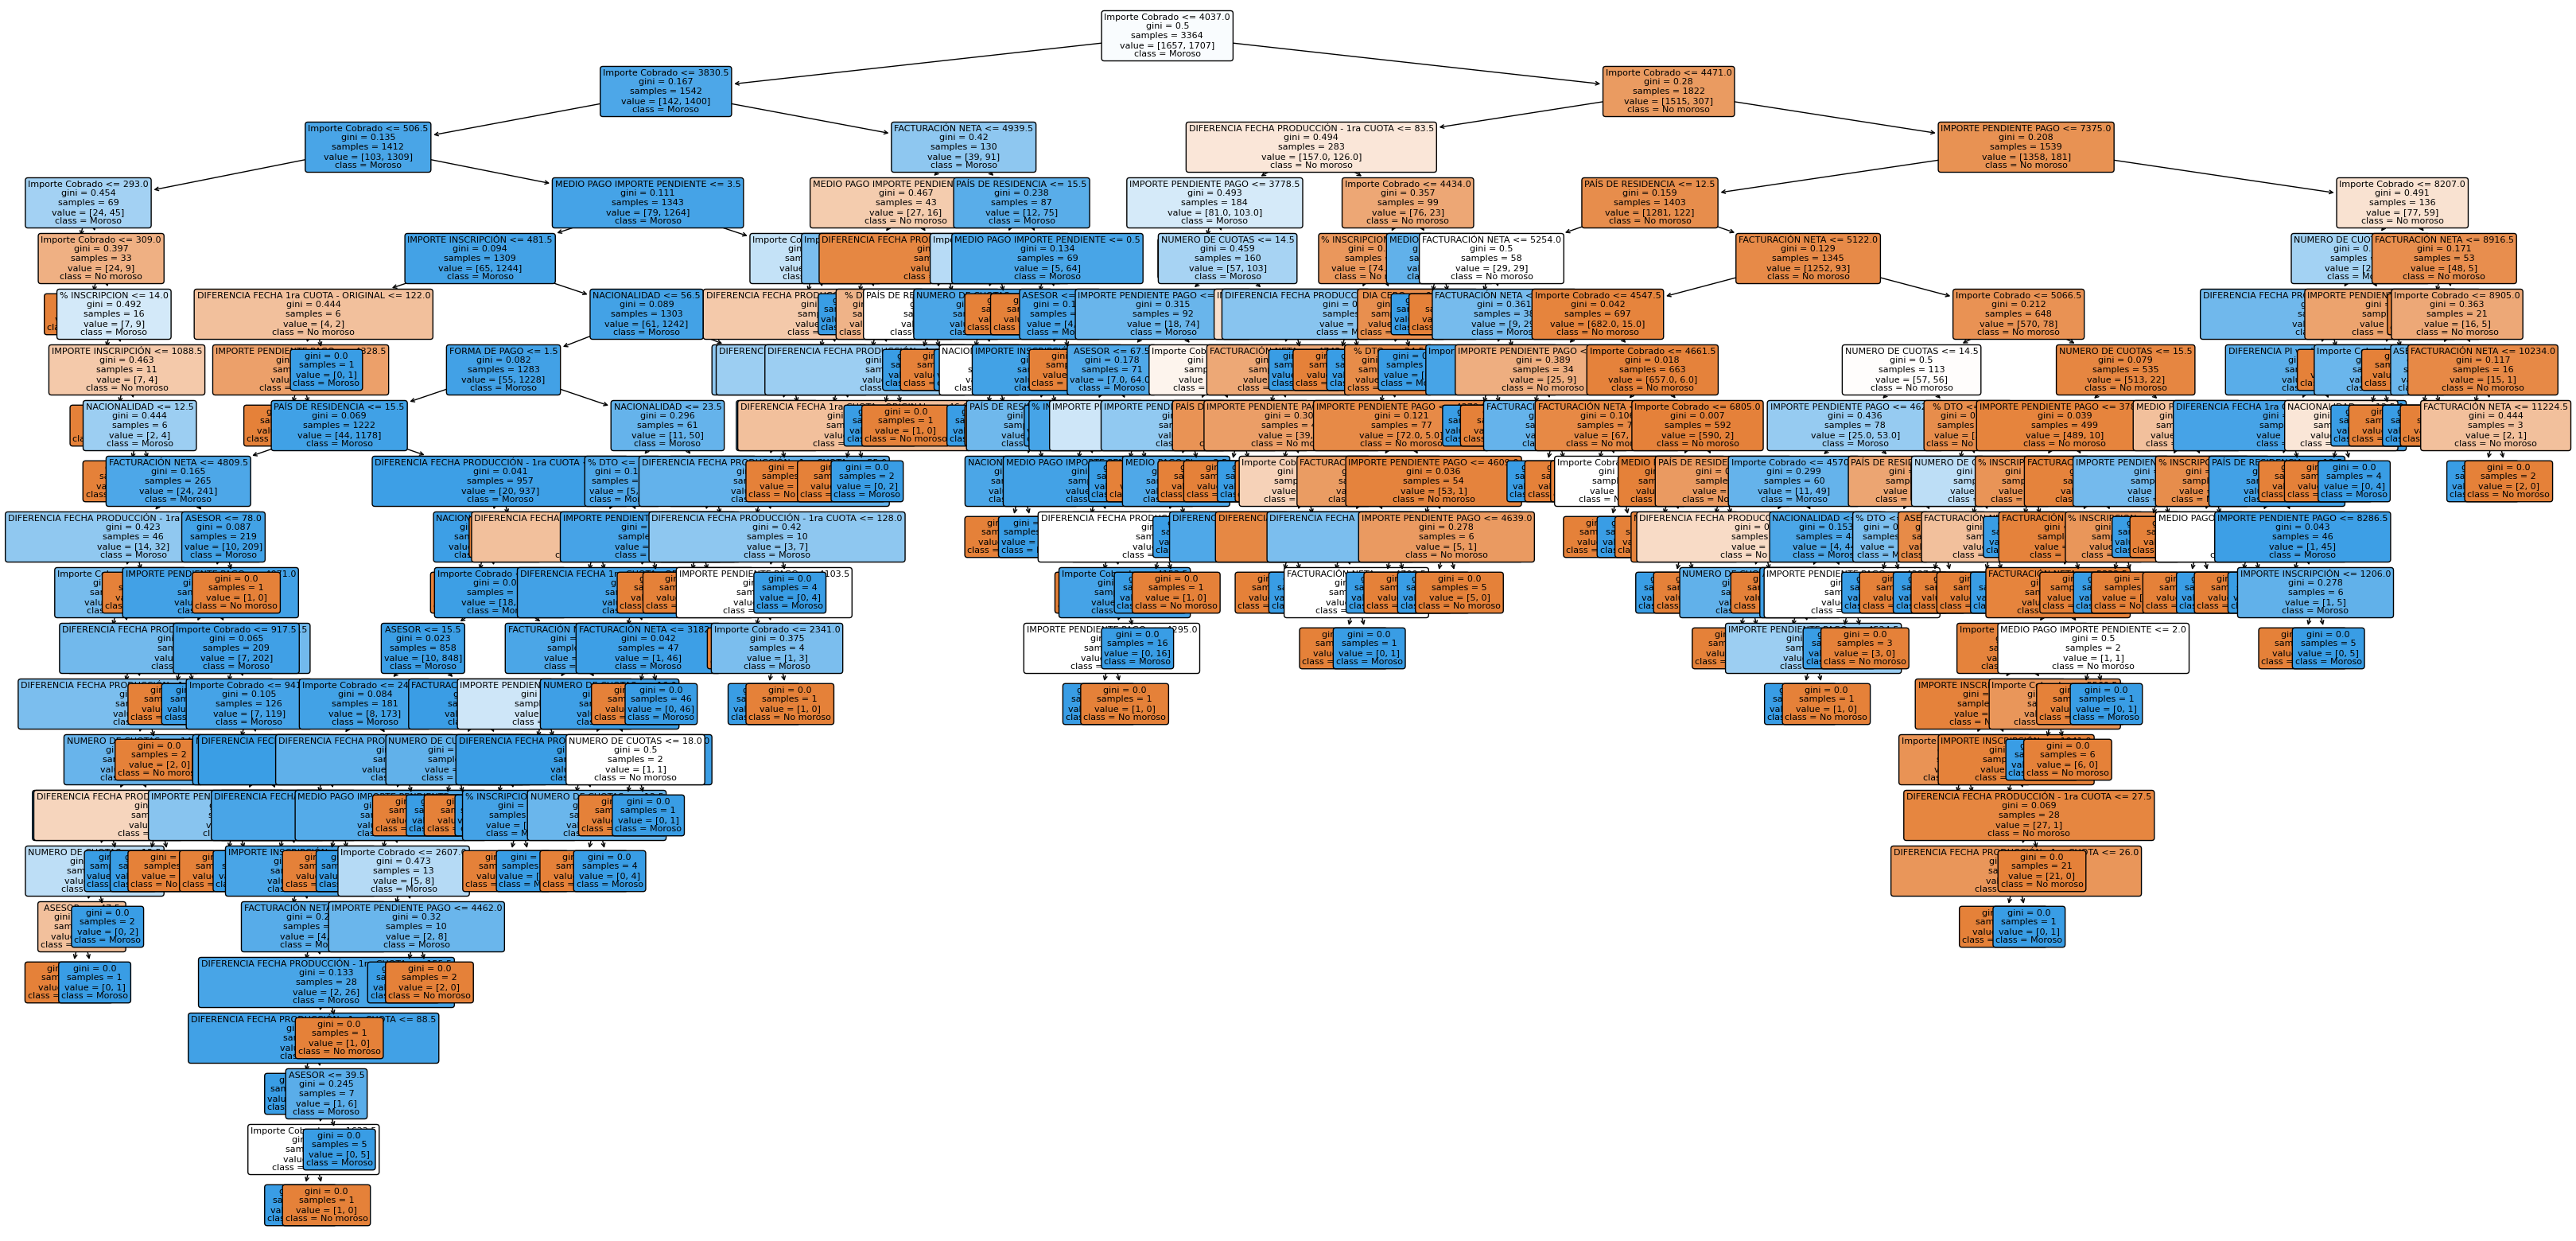

🌳 Imagen del árbol guardada en ..\reports\08-decision_tree_structure.jpg


In [ ]:
columnas_porcenatajes = ['% INSCRIPCION', '% DTO']
df2 = df.copy()

for col in columnas_porcenatajes:
    df2[col] = df2[col] * 100
for col in df2.columns:
    df2[col] = df2[col].round().astype(int)

X = df2.drop(columns=['Moroso'])
y = df2['Moroso'].astype(int)

# Oversampling con SMOTE
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)
df_oversampled = pd.concat([X_res, y_res], axis=1)
X = df_oversampled.drop(columns=['Moroso'])
y = df_oversampled['Moroso'].astype(int)

# Escalar solo para Logistic Regression
scaler = StandardScaler()
X_logistic = scaler.fit_transform(X)

# Modelos
modelos_rapidos = {
    'Random Forest': RandomForestClassifier(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

# Separar para árboles y para regresión logística
X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(
    X_logistic, y, test_size=0.2, random_state=42
)
X_train_tree, X_test_tree, y_train_tree, y_test_tree = train_test_split(
    X, y, test_size=0.2, random_state=42
)


# Entrenar
resultados_rapidos_oversampled = []
modelos_entrenados = {}

for nombre, modelo in modelos_rapidos.items():
    if nombre == 'Logistic Regression':
        modelo.fit(X_train_std, y_train_std)
        y_pred = modelo.predict(X_test_std)
    else:
        modelo.fit(X_train_tree, y_train_tree)
        y_pred = modelo.predict(X_test_tree)
    
    modelos_entrenados[nombre] = modelo

    acc = accuracy_score(y_test_tree, y_pred)
    resultados_rapidos_oversampled.append({
        'Modelo': nombre,
        'Accuracy': acc,
        'Reporte': classification_report(y_test_tree, y_pred, output_dict=True),
        'Matriz Confusión': confusion_matrix(y_test_tree, y_pred)
    })

# Resultados
resumen_rapidos_oversampled = pd.DataFrame({
    'Modelo': [r['Modelo'] for r in resultados_rapidos_oversampled],
    'Accuracy': [r['Accuracy'] for r in resultados_rapidos_oversampled]
}).sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
display(resumen_rapidos_oversampled)

metricas_oversampled = []
for resultado in resultados_rapidos_oversampled:
    reporte = resultado['Reporte']
    metricas_oversampled.append({
        'Modelo': resultado['Modelo'],
        'Precision (Clase 1)': reporte['1']['precision'],
        'Recall (Clase 1)': reporte['1']['recall'],
        'F1-score (Clase 1)': reporte['1']['f1-score'],
        'Precision (Clase 0)': reporte['0']['precision'],
        'Recall (Clase 0)': reporte['0']['recall'],
        'F1-score (Clase 0)': reporte['0']['f1-score']
    })
df_metricas_oversampled = pd.DataFrame(metricas_oversampled).sort_values(
    by='F1-score (Clase 1)', ascending=False
).reset_index(drop=True)
display(df_metricas_oversampled)

# Matriz de confusión
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for ax, resultado in zip(axes, resultados_rapidos_oversampled):
    cm = resultado['Matriz Confusión']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Matriz de Confusión - {resultado["Modelo"]}')
    ax.set_xlabel('Predicho')
    ax.set_ylabel('Real')
plt.tight_layout()
plt.show()

# Guardar modelos
os.makedirs(models_dir, exist_ok=True)

for nombre, modelo in modelos_entrenados.items():
    ruta_modelo = os.path.join(models_dir, f"modelo_{nombre.replace(' ', '_').lower()}.pkl")
    with open(ruta_modelo, "wb") as f:
        pickle.dump(modelo, f)
    print(f"Modelo guardado: {ruta_modelo}")

# GUARDAR ÁRBOL DE DECISIÓN EN ../reports

os.makedirs(reports_dir, exist_ok=True)

dt_model = modelos_entrenados['Decision Tree']
plt.figure(figsize=(40,20))
plot_tree(
    dt_model,
    feature_names=X.columns,
    class_names=['No moroso', 'Moroso'],
    filled=True,
    rounded=True,
    fontsize=8
)
ruta_arbol = os.path.join(reports_dir, "08-decision_tree_structure.jpg")
plt.savefig(ruta_arbol, dpi=300, bbox_inches="tight")
plt.show()
print(f"Imagen del árbol guardada en {ruta_arbol}")


Al hacer el oversampling llegamos a valores precisón del 94% y 93% en RF y DT, respectivamente. 

Además, el F1-score asciende a 94% y 93% para estos dos modelos (6ptos por encima del 88% del DT con undersampling)

In [ ]:
# Guardar los datos de test para la evaluación
test_dir = os.path.join("..", "data", "test")
os.makedirs(test_dir, exist_ok=True)

# Convertir a DataFrame
X_test_std_df = pd.DataFrame(X_test_std, columns=X.columns)  # <-- usa las mismas columnas originales
y_test_std_df = pd.DataFrame(y_test_std, columns=["Moroso"])

# Guardar archivos CSV
X_test_std_df.to_csv(os.path.join(test_dir, "X_test_log.csv"), index=False)
y_test_std_df.to_csv(os.path.join(test_dir, "Y_test_log.csv"), index=False)
X_test_tree.to_csv(os.path.join(test_dir, "X_test.csv"), index=False)
y_test_tree.to_csv(os.path.join(test_dir, "Y_test.csv"), index=False)

## Ajuste de hiperparámetros

### RandomizedSearchCV

In [ ]:
# Decision Tree 
param_dist_dt = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 21),
    'criterion': ['gini', 'entropy']
}

random_dt = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_distributions=param_dist_dt,
    n_iter=30,             # nº de combinaciones a probar
    scoring='f1',
    cv=5,
    random_state=42,
    n_jobs=-1
)

random_dt.fit(X_train_tree, y_train_tree)
best_dt = random_dt.best_estimator_
print("🌳 Mejor Decision Tree:", random_dt.best_params_)

#  Random Forest 
param_dist_rf = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [5, 10, 20, None],
    'min_samples_split': np.arange(2, 21),
    'min_samples_leaf': np.arange(1, 21),
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]
}

random_rf = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist_rf,
    n_iter=40,            # nº de combinaciones a probar
    scoring='f1',
    cv=5,
    random_state=42,
    n_jobs=-1
)

random_rf.fit(X_train_tree, y_train_tree)
best_rf = random_rf.best_estimator_
print("🌲 Mejor Random Forest:", random_rf.best_params_)

# EVALUAR MODELOS OPTIMIZADOS

modelos_optimizados = {
    'Decision Tree Optimizado': best_dt,
    'Random Forest Optimizado': best_rf
}

resultados_optimizados = []

for nombre, modelo in modelos_optimizados.items():
    y_pred = modelo.predict(X_test_tree)
    acc = accuracy_score(y_test_tree, y_pred)
    resultados_optimizados.append({
        'Modelo': nombre,
        'Accuracy': acc,
        'Reporte': classification_report(y_test_tree, y_pred, output_dict=True),
        'Matriz Confusión': confusion_matrix(y_test_tree, y_pred)
    })

df_resultados_opt = pd.DataFrame({
    'Modelo': [r['Modelo'] for r in resultados_optimizados],
    'Accuracy': [r['Accuracy'] for r in resultados_optimizados]
})
display(df_resultados_opt)

# GUARDAR MODELOS OPTIMIZADOS

for nombre, modelo in modelos_optimizados.items():
    ruta_modelo = os.path.join(models_dir, f"modelo_{nombre.replace(' ', '_').lower()}.pkl")
    with open(ruta_modelo, "wb") as f:
        pickle.dump(modelo, f)
    print(f"Modelo optimizado guardado: {ruta_modelo}")


🌳 Mejor Decision Tree: {'min_samples_split': np.int64(8), 'min_samples_leaf': np.int64(3), 'max_depth': 10, 'criterion': 'entropy'}
🌲 Mejor Random Forest: {'n_estimators': 200, 'min_samples_split': np.int64(4), 'min_samples_leaf': np.int64(1), 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}


,Modelo,Accuracy
0,Decision Tree Optimizado,0.928741
1,Random Forest Optimizado,0.952494


Modelo optimizado guardado: ..\models\modelo_decision_tree_optimizado.pkl
Modelo optimizado guardado: ..\models\modelo_random_forest_optimizado.pkl


# Resultados

## Resumen

,Modelo,Accuracy
0,Decision Tree Optimizado,0.928741
1,Random Forest Optimizado,0.952494


,Modelo,Precision (Clase 1),Recall (Clase 1),F1-score (Clase 1),Precision (Clase 0),Recall (Clase 0),F1-score (Clase 0)
0,Random Forest Optimizado,0.954082,0.944444,0.949239,0.951111,0.959641,0.955357
1,Decision Tree Optimizado,0.924242,0.924242,0.924242,0.932735,0.932735,0.932735


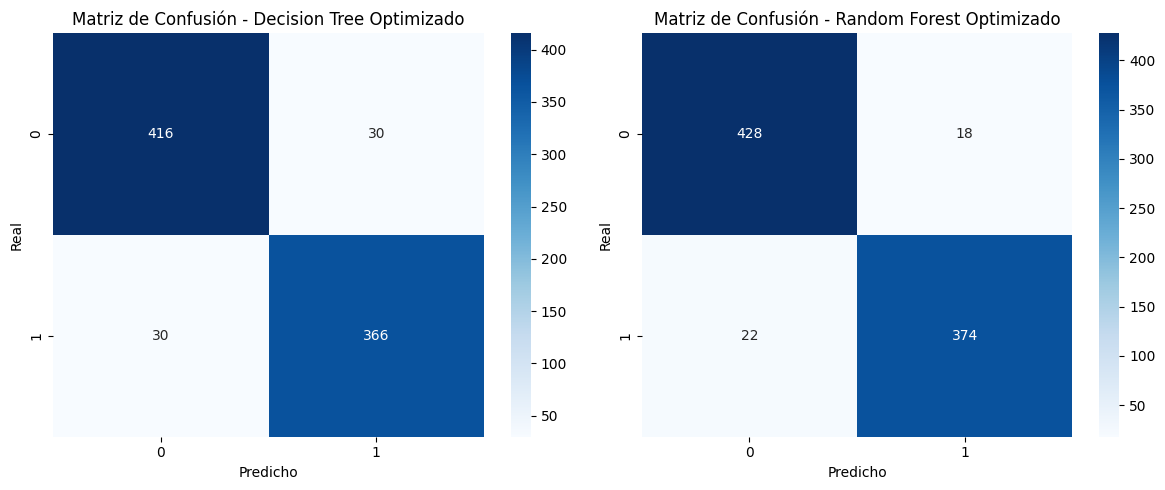

In [ ]:
# Tabla resumen
df_resultados_opt = pd.DataFrame({
    'Modelo': [r['Modelo'] for r in resultados_optimizados],
    'Accuracy': [r['Accuracy'] for r in resultados_optimizados]
})
display(df_resultados_opt)

# Métricas detalladas
metricas_opt = []
for resultado in resultados_optimizados:
    reporte = resultado['Reporte']
    metricas_opt.append({
        'Modelo': resultado['Modelo'],
        'Precision (Clase 1)': reporte['1']['precision'],
        'Recall (Clase 1)': reporte['1']['recall'],
        'F1-score (Clase 1)': reporte['1']['f1-score'],
        'Precision (Clase 0)': reporte['0']['precision'],
        'Recall (Clase 0)': reporte['0']['recall'],
        'F1-score (Clase 0)': reporte['0']['f1-score']
    })
df_metricas_opt = pd.DataFrame(metricas_opt).sort_values(
    by='F1-score (Clase 1)', ascending=False
).reset_index(drop=True)
display(df_metricas_opt)

# Matrices de confusión
fig, axes = plt.subplots(1, len(resultados_optimizados), figsize=(12, 5))
if len(resultados_optimizados) == 1:
    axes = [axes]  # Si hay un solo modelo

for ax, resultado in zip(axes, resultados_optimizados):
    cm = resultado['Matriz Confusión']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f"Matriz de Confusión - {resultado['Modelo']}")
    ax.set_xlabel("Predicho")
    ax.set_ylabel("Real")

plt.tight_layout()
ruta_cm = os.path.join(reports_dir, "09-matrices_confusion_modelos_optimizados.jpg")
plt.savefig(ruta_cm, dpi=300, bbox_inches="tight")
plt.show()

## Esquema Árbol de decisión

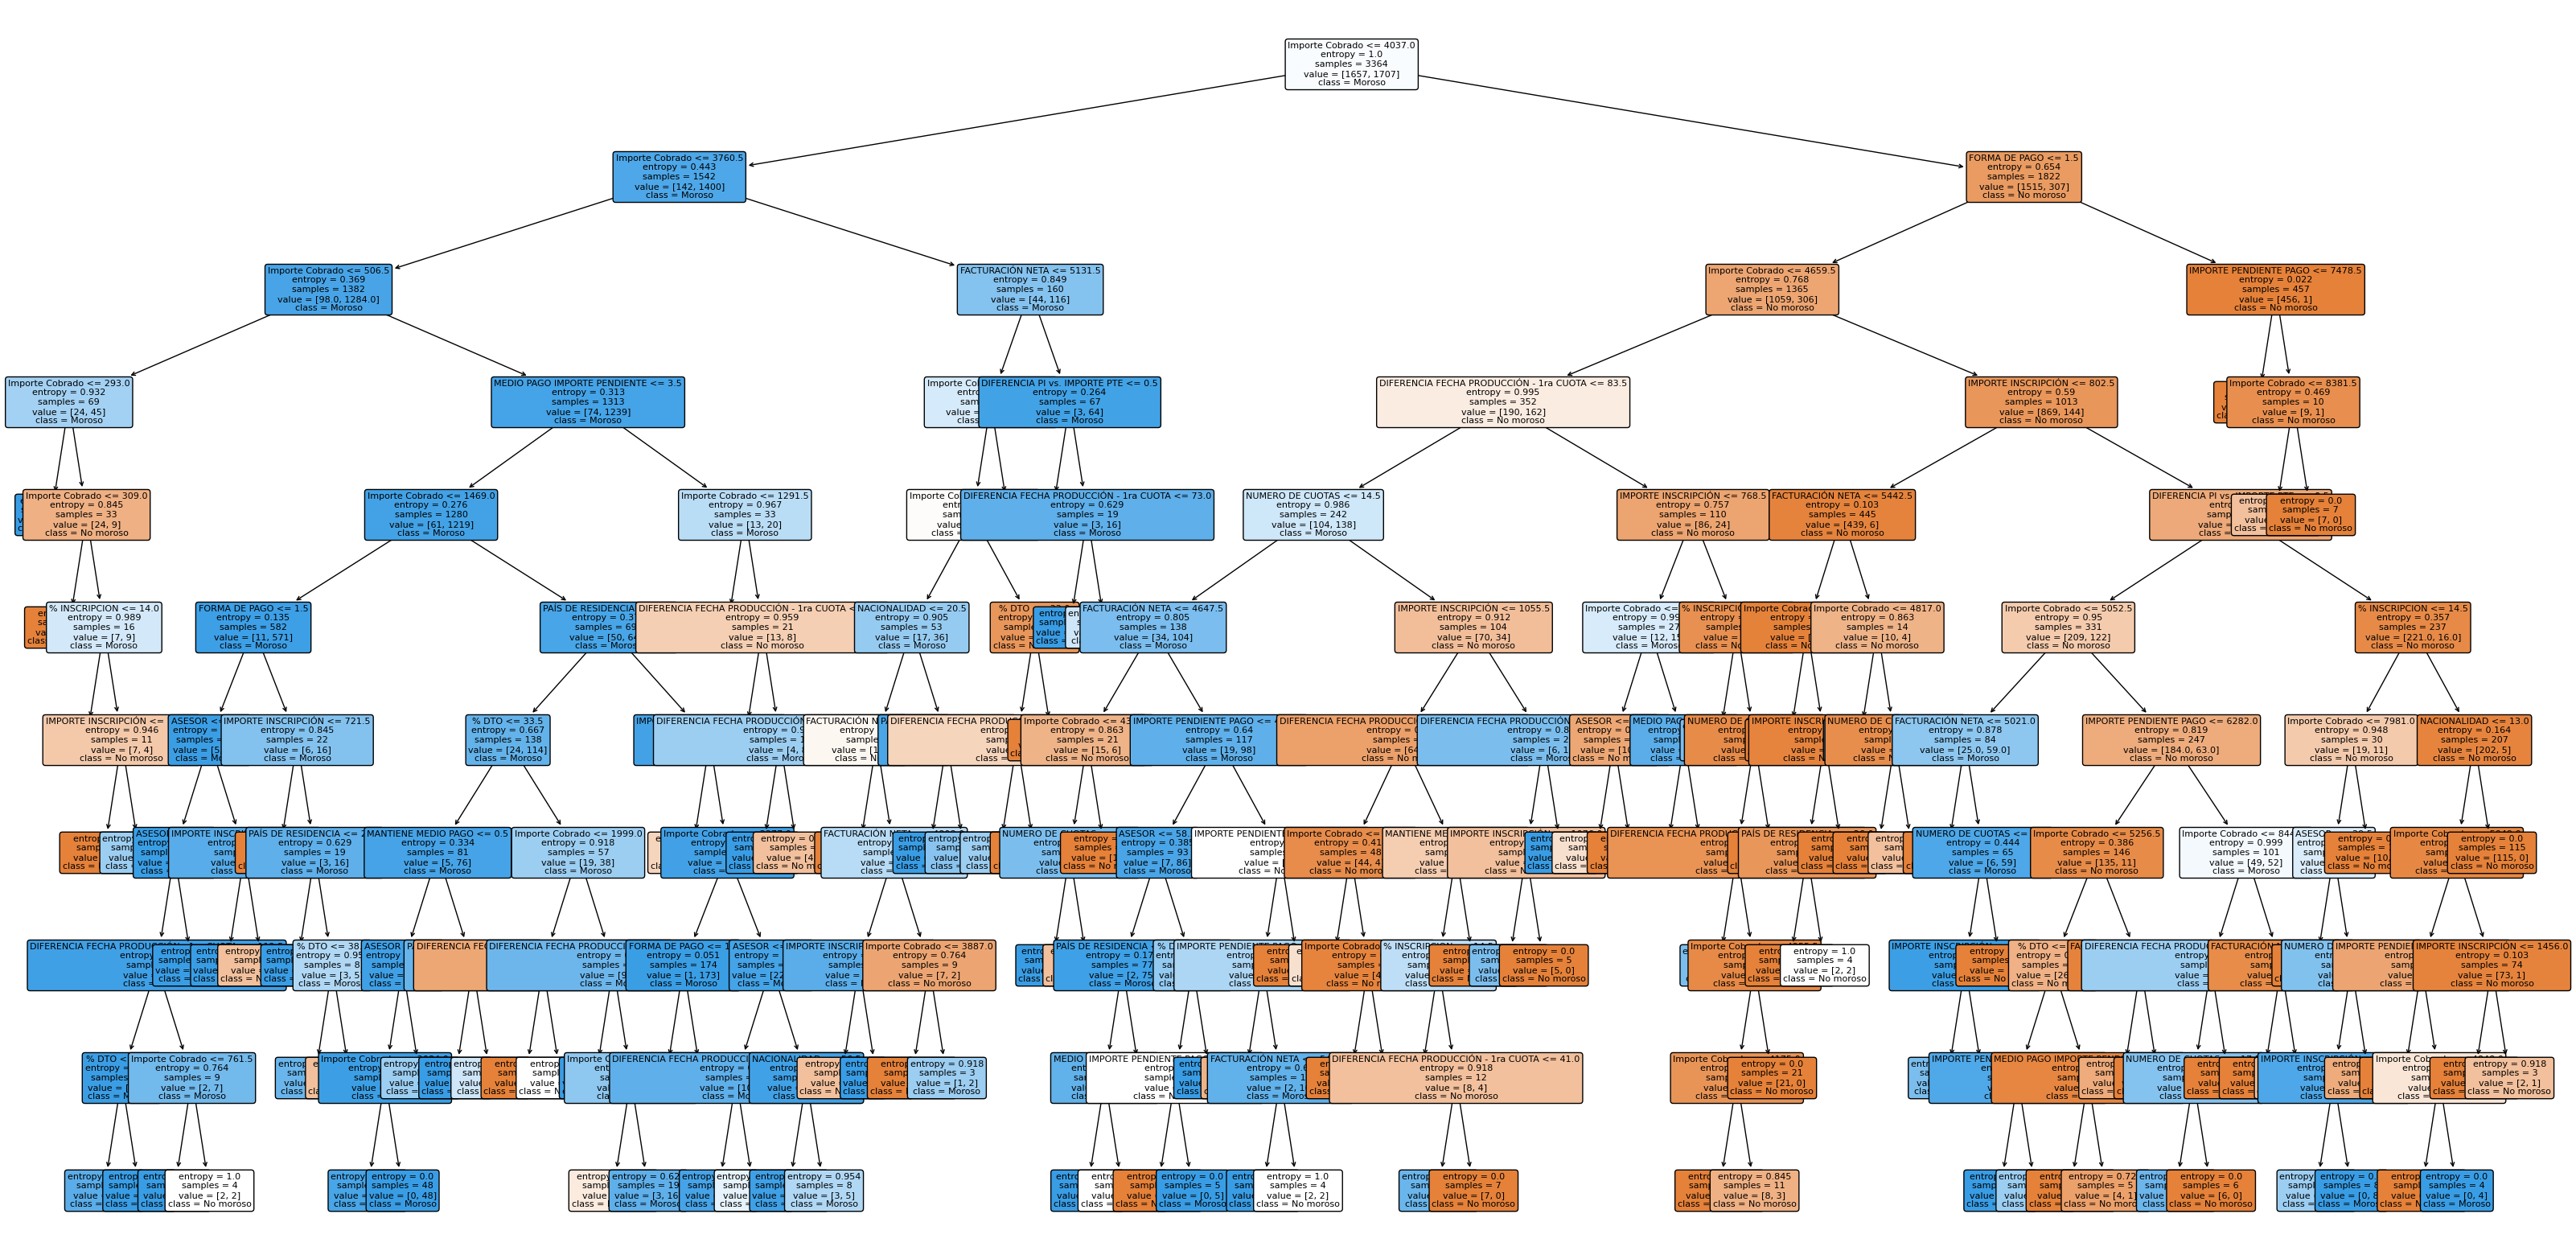

Esquema del Decision Tree guardado en ..\reports\10-decision_tree_structure.jpg


In [40]:
# ESQUEMA DEL DECISION TREE

# Usar el mejor modelo de Decision Tree optimizado
dt_model = best_dt  

# Crear carpeta reports si no existe
os.makedirs(reports_dir, exist_ok=True)

# Dibujar el árbol
plt.figure(figsize=(40, 20))
plot_tree(
    dt_model,
    feature_names=X.columns,
    class_names=['No moroso', 'Moroso'],
    filled=True,
    rounded=True,
    fontsize=8
)

# Guardar imagen
ruta_dt = os.path.join(reports_dir, "10-decision_tree_structure.jpg")
plt.savefig(ruta_dt, dpi=300, bbox_inches="tight")
plt.show()

print(f"Esquema del Decision Tree guardado en {ruta_dt}")

# Conclusión

## Conclusión final del ajuste de modelos

Tras optimizar los hiperparámetros de **Random Forest** y **Decision Tree**, se compararon las métricas de ambos modelos en la clasificación de morosos y no morosos.

### Resultados principales

- **Random Forest Optimizado**
  - Precision (Clase 1): 0.95  
  - Recall (Clase 1): 0.94  
  - F1-score (Clase 1): **0.95**  
  - Precision (Clase 0): 0.95  
  - Recall (Clase 0): 0.96  
  - F1-score (Clase 0): **0.96**

- **Decision Tree Optimizado**
  - Precision (Clase 1): 0.92  
  - Recall (Clase 1): 0.92  
  - F1-score (Clase 1): **0.92**  
  - Precision (Clase 0): 0.93  
  - Recall (Clase 0): 0.93  
  - F1-score (Clase 0): **0.93**

### Conclusión

- El **Random Forest optimizado es el modelo con mejor rendimiento**, alcanzando métricas cercanas al 95% en ambas clases, lo que lo convierte en la opción más robusta para predecir morosidad.  
- El **Decision Tree optimizado ofrece un rendimiento ligeramente inferior**, pero destaca por su **interpretabilidad**, ya que permite entender las reglas de decisión de manera clara.  
- En un entorno productivo, se recomienda:
  - **Random Forest** como modelo principal de predicción.  
  - **Decision Tree** como herramienta de apoyo para la **explicación y comunicación** de los factores que más influyen en la clasificación de morosos.
